# Import

In [1]:
import pandas as pd
import time  # Para adicionar pausas manuais durante o teste
from selenium.webdriver.common.by import By # type: ignore
from selenium.webdriver.support.ui import WebDriverWait # type: ignore
from selenium.webdriver.support import expected_conditions as EC # type: ignore
import undetected_chromedriver as uc
from datetime import datetime
from bs4 import BeautifulSoup
import requests

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Pegar dados brasileirão

In [2]:

def abrir_lista(driver):
    try:
        elementos = driver.find_elements(By.XPATH, '//h3[@class="tw-font-bold tw-leading-l tw-text-l tw-text-n-13-steel"]')
        elementos[0].click()
    except:
        print("Erro ao abrir lista")

def pegar_times(driver):
    abrir_lista(driver)
    resultados = driver.find_elements(By.XPATH, '//span[@class="tw-text-s tw-leading-s"]')
    times = []
    for resultado in resultados:
        element = driver.find_element(By.XPATH, f'//a[contains(., "{resultado.text}")]')
        link = element.get_attribute('href')
        club = {
            "Time": resultado.text,
            "Link": link
        }
        times.append(club)
    df = pd.DataFrame(times)
    return df

def pegar_estatisticas(driver,times):
    estatistica_geral = []
    for _, row in times.iterrows():
        resultado=[]
        clube = row["Time"]
        link = row['Link']
        driver.get(link)
        anuncio(driver)
        resultados = driver.find_elements(By.XPATH, '//div[@class="statistics-value-list tw-flex tw-flex-row"]')
        proximo_jogo = driver.find_elements(By.XPATH, '//div[@class="tw-flex tw-items-center tw-justify-center tw-flex-col tw-min-w-0"]')
        jogo = proximo_jogo[0].text.split('\n')
        try:
            jogo.remove('SO')
            jogo.remove('Em local neutro')
        except:
            pass

        if clube in jogo[7]:
            adversario = jogo[8]
            vitoria = float(jogo[-9])
            empate = float(jogo[-7])
            derrota = float(jogo[-5])
        else:
            vitoria = float(jogo[-5])
            empate = float(jogo[-7])
            derrota = float(jogo[-9])
            adversario = jogo[7]

        #lucro = (1/vitoria + 1/derrota + 1/empate)* 100 - 100
        for item in resultados:
            try:
                tratando = float(item.text)
            except:
                tratando = str(item.text)
                tratando = tratando.replace('D', '0')
                tratando = tratando.replace('V', '1')
                tratando = tratando.replace('E', '0.5')

            resultado.append(tratando)
        try:
            driver.find_element(By.XPATH,  '//div[@class="tw-px-nm tw-py-n tw-rounded-m tw-leading-s tw-text-xs hover:tw-bg-n-90-dark-snow"]').click()
            chance_final = (driver.find_element(By.XPATH, f'//div[@class="table-layout-container tw-bg-white-snow" ]')).text
            chance_final = chance_final.split('\n')
        except:
             chance_final = "Não disponivel"   

        if type(chance_final) == list:
            if chance_final[0] == "Vencedor Final":
                chance_final = round(1/float(chance_final[-1]),3)
            else:
                chance_final = 0
        
        novo = resultado[5].split('-')
        saldo = round(int(novo[0]) / int(novo[1]), 2)
        if type(resultado[13]) == str:
            resultado[13]= resultado[13].replace('-', '0')
        
        
        estatistica = {
            "Time": clube,
            "Adversario": adversario,
            "Vitoria": round(1/vitoria,2),
            "derrota": round(1/derrota,2),
            "empate": round(1/empate,2),
            #"lucro": round(lucro,2),
            "Jogo-1": float(resultado[0]),"Jogo-2": float(resultado[1]),"Jogo-3": float(resultado[2]),"Jogo-4": float(resultado[3]),"Jogo-5": float(resultado[4]),
            "Saldo de gols": saldo,
            "Posse de bola": float(resultado[6].replace('%',''))/100,
            "Ataque": resultado[7],
            "Chutes": resultado[8],
            "Escanteios": resultado[9],
            "Gols tomados": resultado[10],
            "Jogos sem gols": resultado[11],
            "Cartão amarelo": resultado[12],
            "Cartão vermelho": float(resultado[13]),
            "Campeão": chance_final
        }
        estatistica_geral.append(estatistica)
    estatistica_geral = pd.DataFrame(estatistica_geral)

    return estatistica_geral
def anuncio(driver):
    try:
        close_button = driver.find_element(By.CLASS_NAME, 'sb-modal__close__btn')
        close_button.click()
    except:
        pass

def betano():
    try:

        driver = uc.Chrome()

        timao = "https://br.betano.com/sport/futebol/competicoes/brasil/10016/corinthians/107253-t/"
        driver.get(timao)
        anuncio(driver)

        dados = pegar_times(driver)

        estatistica_betano = pegar_estatisticas(driver,dados)
        # Obtém a data e hora atual
        data_atual = datetime.now()

        # Formata a data como string
        data_formatada = data_atual.strftime("%d-%m")
        driver.quit()
        #return estatistica_betano.to_excel(f"betano-{data_formatada}.xlsx", index=False)
        return estatistica_betano
        
    except Exception as e:
        print(e)
        #driver.quit()

In [3]:
df = betano()

In [9]:
df#.head(2)

,Time,Adversario,Vitoria,derrota,empate,Jogo-1,Jogo-2,Jogo-3,Jogo-4,Jogo-5,Saldo de gols,Posse de bola,Ataque,Chutes,Escanteios,Gols tomados,Jogos sem gols,Cartão amarelo,Cartão vermelho,Campeão
0,Athletico-PR,Botafogo-RJ,0.33,0.40,0.31,0.0,0.0,0.0,0.5,0.5,0.90,0.50,1.29,11.4,6.5,1.28,6.0,2.5,0.2,0.000
1,Atlético-GO,Criciúma,0.22,0.53,0.30,1.0,1.0,0.0,0.0,0.0,0.49,0.46,1.10,10.3,4.5,1.35,4.0,2.7,0.4,0.000
2,Botafogo-RJ,Athletico-PR,0.40,0.33,0.31,0.5,1.0,1.0,1.0,0.5,1.84,0.52,1.45,10.5,5.8,1.06,12.0,2.9,0.1,0.408
3,Bragantino,Palmeiras,0.24,0.52,0.29,0.0,1.0,0.5,0.0,0.5,0.89,0.47,1.04,10.2,5.1,1.32,3.0,2.9,0.1,0.000
4,Atlético-MG,Vitória,0.62,0.16,0.26,0.0,1.0,0.0,1.0,0.0,0.95,0.59,1.27,10.4,5.1,1.20,6.0,2.5,0.3,0.000
5,Corinthians,Internacional,0.41,0.32,0.32,0.5,0.0,1.0,0.0,1.0,0.75,0.49,1.16,10.8,5.6,1.27,6.0,2.8,0.2,0.000
6,Criciúma,Atlético-GO,0.53,0.22,0.30,1.0,0.0,0.0,0.5,1.0,0.81,0.44,1.13,10.5,4.6,1.40,4.0,2.6,0.1,0.000
7,Cruzeiro,Fluminense,0.28,0.44,0.33,0.0,0.5,1.0,0.0,0.5,1.25,0.52,1.03,10.0,5.6,1.15,11.0,2.5,0.1,0.000
8,Cuiabá,São Paulo,0.32,0.39,0.34,0.0,1.0,0.5,0.0,0.5,0.59,0.44,0.92,8.2,4.0,1.29,6.0,2.8,0.0,0.000
9,Bahia,Flamengo,0.42,0.32,0.31,1.0,0.5,0.0,1.0,0.0,1.26,0.57,1.33,10.0,4.7,1.05,9.0,2.2,0.0,0.001


# Gerando visualizações

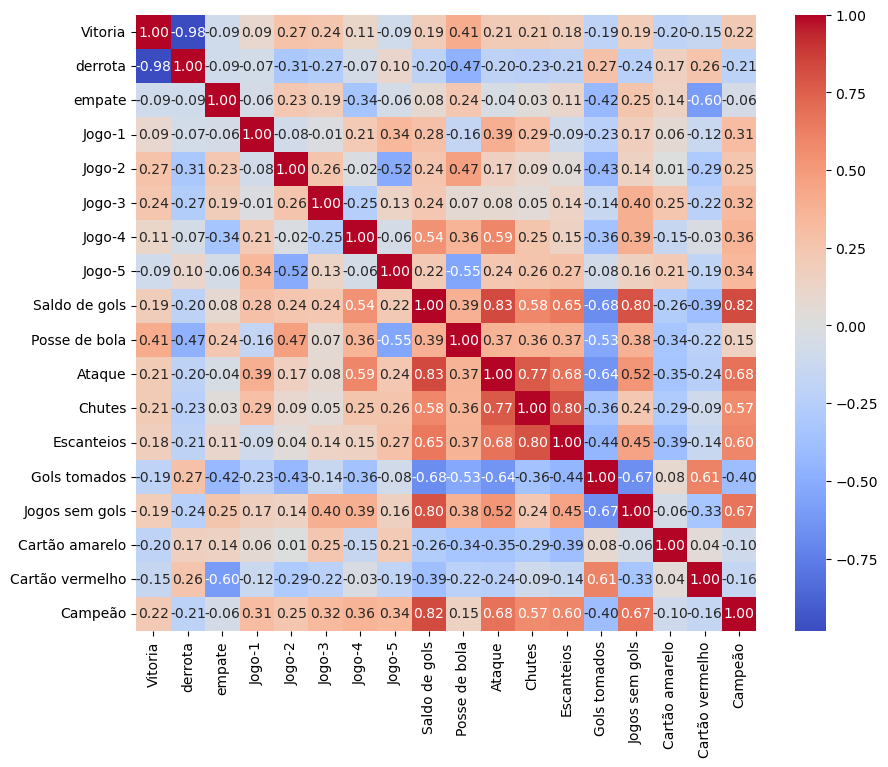

In [6]:
dados = df.drop(['Adversario', 'Time'], axis=1)
matriz_corelacao1 = dados.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corelacao1, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [12]:
lista = list(df[0:19].values)
print(lista[0])#time 1
print(lista[2])# time 2

['Athletico-PR' 'Botafogo-RJ' 0.33 0.4 0.31 0.0 0.0 0.0 0.5 0.5 0.9 0.5
 1.29 11.4 6.5 1.28 6.0 2.5 0.2 0.0]
['Botafogo-RJ' 'Athletico-PR' 0.4 0.33 0.31 0.5 1.0 1.0 1.0 0.5 1.84 0.52
 1.45 10.5 5.8 1.06 12.0 2.9 0.1 0.408]


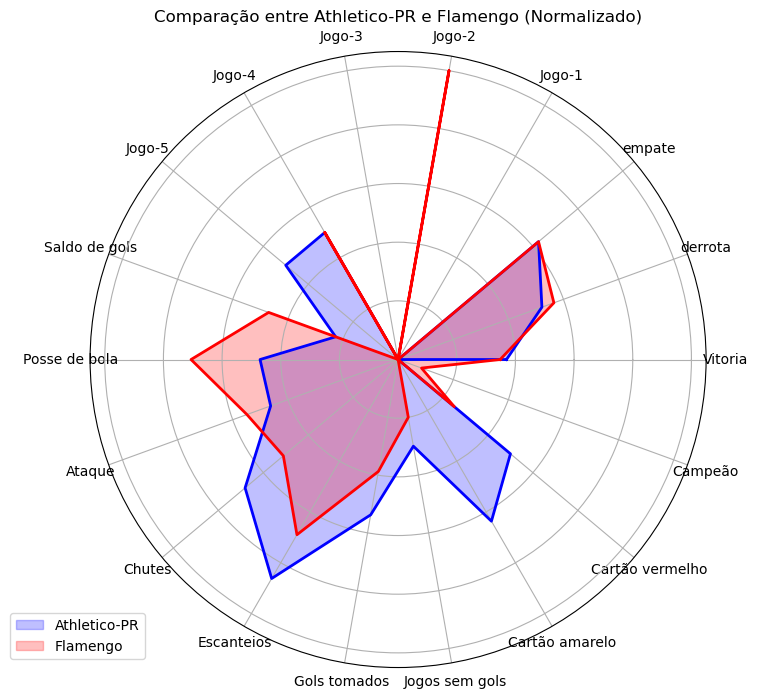

In [13]:
# Seu DataFrame

# Normalização Min-Max
df_normalized = (dados - dados.min()) / (dados.max() - dados.min())

# Selecionar as linhas para comparar
linha1 = df_normalized.iloc[0]
time1 = lista[0][0]
linha2 = df_normalized.iloc[10]
time2 = lista[10][0]

# Categorias (nomes das colunas)
categories = list(dados.columns)

# Número de categorias
N = len(categories)

# Ângulos para cada categoria
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()

# Fechar o gráfico (voltar ao ponto inicial)
linha1 = linha1.tolist() + linha1.tolist()[:1]
linha2 = linha2.tolist() + linha2.tolist()[:1]
angles += angles[:1]

# Plotar o gráfico
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.fill(angles, linha1, color='blue', alpha=0.25, label=time1)
ax.fill(angles, linha2, color='red', alpha=0.25, label=time2)

ax.plot(angles, linha1, color='blue', linewidth=2)
ax.plot(angles, linha2, color='red', linewidth=2)

# Ajustar os rótulos das categorias
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title(f'Comparação entre {time1} e {time2} (Normalizado)')
plt.show()

# Pegando Jogadores 

In [35]:
driver = uc.Chrome()

sofascore = "https://www.sofascore.com/pt/torneio/futebol/brazil/brasileirao-serie-a/325#id:58766"
driver.get(sofascore)
jogadores = []
# Coleta os links de cada clube
links = driver.find_elements(By.XPATH, '//a[@data-testid="standings_row"]')
hrefs = [link.get_attribute('href') for link in links]
# carrega os elementos de clubes
for link in hrefs:
    # carrega os elementos de clubes


    clube = (link.split('/')[-2]) # Atualiza o nome do clube aqui


    driver.get(link)

    # Clicar no botão "Expandir mais"
    try:
        mais = WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[style="cursor: pointer; padding: 0px;"]')))
        mais.click()
    except Exception as e:
        print(f"Erro ao clicar em 'Expandir mais' do clube: {clube}")
        continue

    # Pegando a lista de atletas e notas
    try:
        box = WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.XPATH, '//div[@class="Box idbnlH"]')))
        atletas = box.find_elements(By.TAG_NAME, 'a')
        scores = box.find_elements(By.TAG_NAME, 'span')

        notas = [score.get_attribute('aria-valuenow') for score in scores if score.get_attribute('aria-valuenow') is not None]
        #jogadores = []
        
        for n in range(min(len(atletas), len(notas))):
            try:
                player_name = atletas[n].find_element(By.XPATH, './/span[contains(@class, "Text") and contains(@class, "ietnEf")]').text
                player_position = atletas[n].find_element(By.XPATH, './/span[contains(@class, "Text") and contains(@class, "eMhAJJ")]').text
                nota = notas[n]
                jogador = {
                    "Time": clube,
                    "Nome": player_name,
                    "Posição": player_position,
                    "Score": nota
                }
                jogadores.append(jogador)
            except Exception as e:
                print(f"Erro ao processar jogador: {e}")
        
        # Salva os dados por club
        #df = pd.DataFrame(jogadores)
        #df.to_excel(f'Jogadores-{clube}.xlsx', index=False)

    except Exception as e:
        print(f"Erro ao processar jogadores e notas: {e}")
# salvar dados de todos jogadores
df = pd.DataFrame(jogadores)
df.to_excel(f'Jogadores-brasileirão.xlsx', index=False)

In [36]:
df.head(2)

,Time,Nome,Posição,Score
0,botafogo,Adryelson,Defensor,7.30
1,botafogo,John Victor,Goleiro,7.27
